In [1]:
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

import numpy as np
import os
import uproot

%matplotlib inline
%load_ext autoreload 
%autoreload 2

Import the root files into a DataFrame


In [2]:
# # Define the base directory and the range of subdirectories
# base_dir = "/eos/user/d/dvoss/Run3ModelGen/6249447/"
# subdir_range = range(0, 2)  # Adjust range to include subdirectories to 20

# # List to store data from all files
# all_data = []

# for subdir in subdir_range:
#     file_path = os.path.join(base_dir, str(subdir), f"ntuple.6249447.{subdir}.root")
    
#     try:
#         # Open the ROOT file
#         file = uproot.open(file_path)
        
#         # Assuming the data you want is in a specific tree
#         tree_name = "susy"  # Replace with the actual tree name
#         tree = file[tree_name]
        
#         # Convert tree to pandas DataFrame or any other format you prefer
#         df = tree.arrays(library="pd")
        
#         # Append the DataFrame to the list
#         all_data.append(df)
        
#     except Exception as e:
#         print(f"Failed to open or process {file_path}: {e}")

# # Concatenate all DataFrames into a single DataFrame if using pandas
# import pandas as pd
# final_df = pd.concat(all_data, ignore_index=True)

In [4]:
import pandas as pd
final_df = pd.read_csv("output.csv")

Split into training and validation data:

In [9]:
M_1 = final_df['IN_M_1']
M_2 = final_df['IN_M_2']
Omega = final_df['MO_Omega']

# Filter Omega, M_1, and M_2 up to max 1.0 and limit to only 100 points
mask = (Omega > 0) & (Omega < 1.0)

# Apply the mask to filter M_1, M_2, and Omega
M_1_filtered = M_1[mask]
M_2_filtered = M_2[mask]
Omega_filtered = Omega[mask]

n_points = 50
n_train = 30
n_test = 100000

# Limit to only 100 points
M_1_limited = M_1_filtered.iloc[:n_points]
M_2_limited = M_2_filtered.iloc[:n_points]
Omega_limited = Omega_filtered.iloc[:n_points]

# Convert to train
x_train = torch.stack([torch.tensor(M_1_limited.values[:n_train], dtype=torch.float32), torch.tensor(M_2_limited.values[:n_train], dtype=torch.float32)], dim=1)
y_train = torch.log(torch.tensor(Omega_limited.values[:n_train], dtype=torch.float32)/0.12)


# Convert to valid
x_valid = torch.stack([torch.tensor(M_1_limited.values[n_train:], dtype=torch.float32), torch.tensor(M_2_limited.values[n_train:], dtype=torch.float32)], dim=1)
y_valid = torch.log(torch.tensor(Omega_limited.values[n_train:], dtype=torch.float32)/0.12)

Scatterplot of all individual points 

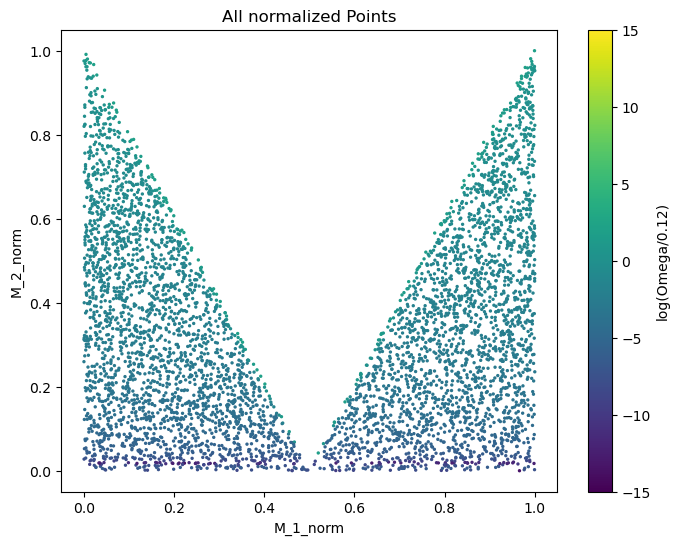

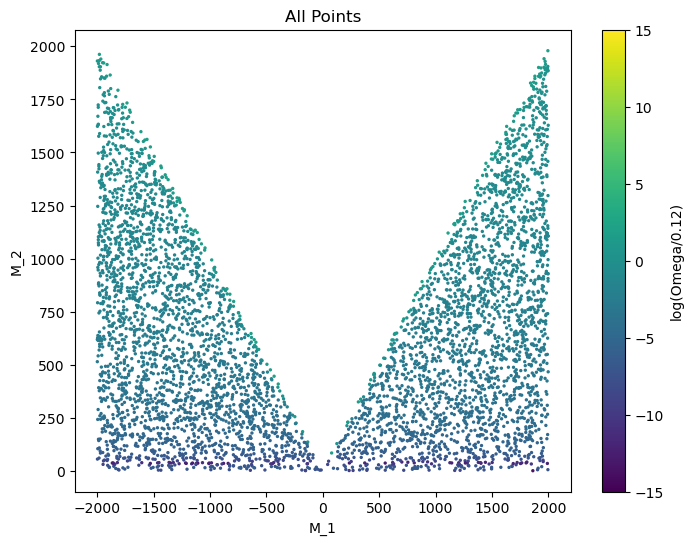

In [10]:
# Normalisierung der Daten auf min = 0 und maximum = 1
# Min-Max-Normalisierung für M_1
M_1_min = M_1_filtered.min()
M_1_max = M_1_filtered.max()
M_1_norm = (M_1_filtered - M_1_min) / (M_1_max - M_1_min)

# Min-Max-Normalisierung für M_2
M_2_min = M_2_filtered.min()
M_2_max = M_2_filtered.max()
M_2_norm = (M_2_filtered - M_2_min) / (M_2_max - M_2_min)

# Plot normalized values
plt.figure(figsize=(8, 6))
plt.scatter(M_1_norm, M_2_norm, c = torch.log(torch.tensor(Omega_filtered, dtype=torch.float32)/0.12), vmin=-15, vmax=15, s = 2)
plt.colorbar(label='log(Omega/0.12)')
plt.xlabel('M_1_norm')
plt.ylabel('M_2_norm')
plt.title('All normalized Points')
plt.show()

# Plot normal values
plt.figure(figsize=(8, 6))
plt.scatter(M_1_filtered, M_2_filtered, c = torch.log(torch.tensor(Omega_filtered, dtype=torch.float32)/0.12), vmin=-15, vmax=15, s = 2)
plt.colorbar(label='log(Omega/0.12)')
plt.xlabel('M_1')
plt.ylabel('M_2')
plt.title('All Points')
plt.show()

In [11]:
for i in (x_train, y_train, x_valid, y_valid):
    print(torch.isinf(i).any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)


Normalization of data

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(M_1_limited.values[:1000], M_2_limited.values[:1000], c = torch.log(torch.tensor(Omega, dtype=torch.float32)/0.12)_train, vmin=-15, vmax=15)
plt.colorbar(label='log(Omega/0.12)')
plt.xlabel('M_1')
plt.ylabel('M_2')
plt.title('Normalized Training Points')
plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2490909478.py, line 2)

In [ ]:
# # Normalisierung der Daten
# x_train = (x_train - x_train.mean(dim=0)) / x_train.std(dim=0)
# x_valid = (x_valid - x_valid.mean(dim=0)) / x_valid.std(dim=0)

# Normalisierung der Daten auf min = 0 und maximum = 1
# Min-Max-Normalisierung für x_train
x_train_min = x_train.min(dim=0, keepdim=True).values
x_train_max = x_train.max(dim=0, keepdim=True).values
x_train = (x_train - x_train_min) / (x_train_max - x_train_min)

# Min-Max-Normalisierung für x_valid
x_valid_min = x_valid.min(dim=0, keepdim=True).values
x_valid_max = x_valid.max(dim=0, keepdim=True).values
x_valid = (x_valid - x_valid_min) / (x_valid_max - x_valid_min)

Scatter plot of all normalized values

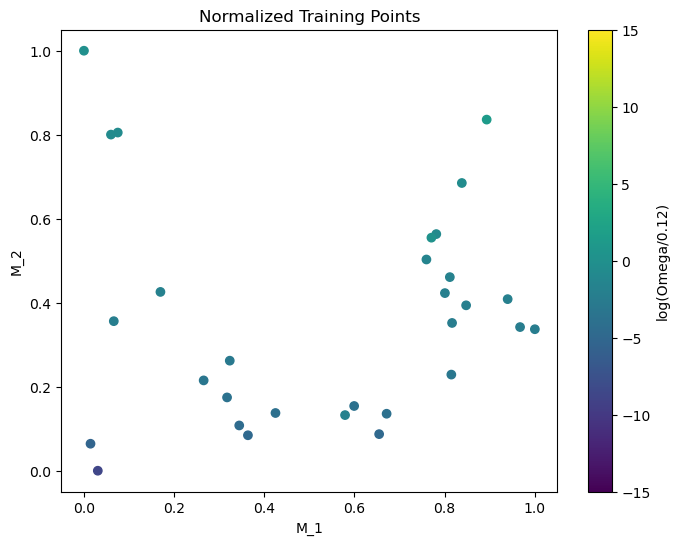

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train[:,0], x_train[:,1], c = y_train, vmin=-15, vmax=15)
plt.colorbar(label='log(Omega/0.12)')
plt.xlabel('M_1')
plt.ylabel('M_2')
plt.title('Normalized Training Points')
plt.show()


In [ ]:
from multitaskGP2D import MultitaskGP2D


likelihood = GaussianLikelihood()
multitask_gp = MultitaskGP2D(x_train, y_train, x_valid, y_valid, likelihood, 2)

best_multitask_gp, losses, losses_valid = multitask_gp.do_train_loop(iters=500)

weights: torch.Size([2, 1])
X: torch.Size([30, 2])
X: tensor([[0.3444, 0.1078],
        [0.8931, 0.8360],
        [0.8475, 0.3938],
        [0.0662, 0.3561],
        [0.8164, 0.3518],
        [0.5791, 0.1325],
        [0.0599, 0.8003],
        [0.9672, 0.3420],
        [0.3234, 0.2620],
        [0.5992, 0.1541],
        [0.3637, 0.0844],
        [0.7595, 0.5029],
        [0.0750, 0.8052],
        [0.0000, 1.0000],
        [0.8148, 0.2289],
        [0.8114, 0.4610],
        [0.6712, 0.1357],
        [0.7814, 0.5634],
        [0.3174, 0.1745],
        [0.8381, 0.6851],
        [0.0146, 0.0643],
        [0.7706, 0.5549],
        [0.2655, 0.2150],
        [0.4248, 0.1374],
        [0.8005, 0.4229],
        [0.1696, 0.4257],
        [0.6547, 0.0871],
        [0.9397, 0.4086],
        [0.0307, 0.0000],
        [1.0000, 0.3369]])
weights: Parameter containing:
tensor([[0.1000],
        [0.1000]], requires_grad=True)
Iteration 0: x_train shape: torch.Size([30, 2]), y_train shape: torch.Size([3

Save Model in ONNX

In [ ]:
# import torch.onnx

# # Put the model in evaluation mode
# best_multitask_gp.eval()

# # Create a dummy input tensor with the same shape as the model input
# dummy_input = x_train[:1]  # Adjust based on the input shape expected by your model

# # Export the model to ONNX format
# torch.onnx.export(
#     best_multitask_gp,           # Model to be exported
#     dummy_input,                 # Dummy input tensor
#     "multitask_gp_model.onnx",   # Output file name
#     export_params=True,          # Store the trained parameter weights inside the model file
#     opset_version=11,            # The ONNX version to export the model to
#     do_constant_folding=True,    # Whether to execute constant folding for optimization
#     input_names=['input'],       # The model's input names
#     output_names=['output'],     # The model's output names
#     dynamic_axes={'input': {0: 'batch_size'},  # Variable length axes
#                   'output': {0: 'batch_size'}}
# )

Plot losses

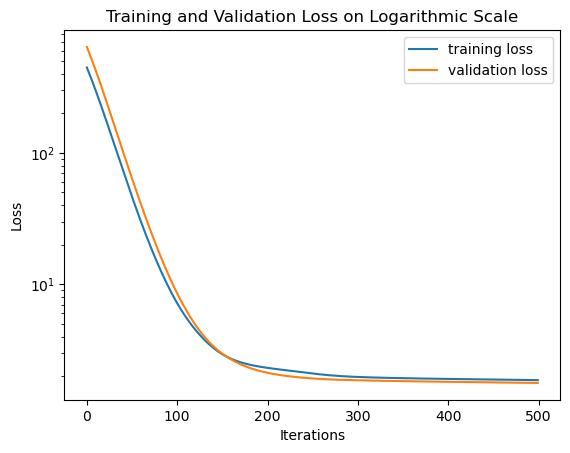

In [ ]:
# Erstellen des Plots
plt.plot(losses, label='training loss')
plt.plot(losses_valid, label='validation loss')

# Setzen der y-Achse auf logarithmische Skala
plt.yscale('log')

# Hinzufügen der Legende
plt.legend()

# Achsenbeschriftungen und Titel hinzufügen (optional)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss on Logarithmic Scale')

# Anzeigen des Plots
plt.show()

Best parameters:

In [ ]:
best_multitask_gp.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([1.0244])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.weights',
              tensor([[-1.1033],
                      [ 0.0832]])),
             ('mean_module.bias', tensor([-0.7752])),
             ('covar_module.raw_lengthscale', tensor([[-0.6467]])),
             ('covar_module.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('task_covar_module.covar_factor', tensor([[-0.6667]])),
             ('task_covar_module.raw_var', tensor([-0.2973])),
             ('task_covar_module.IndexKernelPrior.a', tensor([0.])),
             ('task_covar_module.IndexKernelPrior.b', tensor([1.])),
             ('task_covar_modu

In [ ]:
params = best_multitask_gp.named_parameters()

for name, param in params:
    print(f"Name: {name}, Value: {param.data}")

Name: likelihood.noise_covar.raw_noise, Value: tensor([1.0244])
Name: mean_module.weights, Value: tensor([[-1.1033],
        [ 0.0832]])
Name: mean_module.bias, Value: tensor([-0.7752])
Name: covar_module.raw_lengthscale, Value: tensor([[-0.6467]])
Name: task_covar_module.covar_factor, Value: tensor([[-0.6667]])
Name: task_covar_module.raw_var, Value: tensor([-0.2973])


Evaluate on test data & get entropy

In [ ]:
# x_test = torch.stack([torch.tensor(M_1_filtered.values[n_points:n_test], dtype=torch.float32), torch.tensor(M_2_filtered.values[n_points:n_test], dtype=torch.float32)], dim=1)
x_test = torch.stack([torch.tensor(M_1.values[n_points:n_test], dtype=torch.float32), torch.tensor(M_2.values[n_points:n_test], dtype=torch.float32)], dim=1)


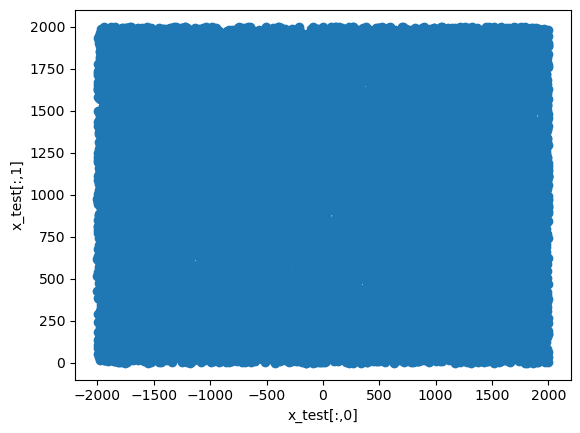

In [ ]:
plt.xlabel("x_test[:,0]")
plt.ylabel("x_test[:,1]")
plt.scatter(x_test[:,0], x_test[:,1])

In [ ]:
# # Normalisierung der Daten
# x_test = (x_test - x_test.mean(dim=0)) / x_test.std(dim=0)

# Normalisierung der Daten auf min = 0 und maximum = 1
# Min-Max-Normalisierung für x_train
x_test_min = x_test.min(dim=0, keepdim=True).values
x_test_max = x_test.max(dim=0, keepdim=True).values
x_test = (x_test - x_test_min) / (x_test_max - x_test_min)


Take linspace x_test

In [ ]:
# Determine the number of points
num_points = 10000

# Generate random values between 0 and 1 for M_1 and M_2
M_1_random = torch.rand(num_points)
M_2_random = torch.rand(num_points)

# Stack the random points together
x_test_rand = torch.stack([M_1_random, M_2_random], dim=1)

In [ ]:
# from PublishGP.utils import entropy_local
from entropy import entropy_local 

def evaluate(multitask_gp, likelihood, x_test):
    """Evaluate GP on test sample and calculate corresponding entropies."""

    multitask_gp.eval()
    likelihood.eval()

    with torch.no_grad():
        # Get prediction:
        observed_pred = likelihood(multitask_gp(x_test))

        # Get upper and lower confidence bounds
        mean = observed_pred.mean.detach().reshape(-1, 1)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        dtype = torch.float32
        var = observed_pred.variance.detach().reshape(-1, 1)
        thr = torch.Tensor([0.]) # Threshold in CDF calculation. Needs to be more sophisticated if params are scaled.

        entropy = entropy_local(mean, var, thr, device, dtype)
        
    return observed_pred, entropy

observed_pred, entropy = evaluate(multitask_gp, likelihood, x_test)
observed_pred_rand, entropy_rand = evaluate(multitask_gp, likelihood, x_test_rand)

weights: torch.Size([2, 1])
X: torch.Size([10163, 2])
X: tensor([[0.3444, 0.1078],
        [0.8931, 0.8360],
        [0.8475, 0.3938],
        ...,
        [0.0792, 0.5994],
        [0.2469, 0.4549],
        [0.0294, 0.3128]])
weights: Parameter containing:
tensor([[-1.1033],
        [ 0.0832]], requires_grad=True)
weights: torch.Size([2, 1])
X: torch.Size([10030, 2])
X: tensor([[0.3444, 0.1078],
        [0.8931, 0.8360],
        [0.8475, 0.3938],
        ...,
        [0.7700, 0.3195],
        [0.5406, 0.6006],
        [0.7433, 0.0262]])
weights: Parameter containing:
tensor([[-1.1033],
        [ 0.0832]], requires_grad=True)


Plot the True Function next to the GP:

In [ ]:
mean = observed_pred.mean.numpy()
mean_rand = observed_pred_rand.mean.numpy()

print(x_test.shape)
print(x_train.shape)
print(torch.tensor(mean).shape)
print(y_train.shape)
print(torch.tensor(mean))
print(y_train)

torch.Size([10133, 2])
torch.Size([30, 2])
torch.Size([10133])
torch.Size([30])
tensor([-3.1590, -3.9464, -1.3418,  ..., -1.3274, -2.1115, -3.1038])
tensor([-4.4654,  1.3038, -2.1413, -2.3365, -2.3627, -1.9721, -0.6459, -2.4172,
        -2.9111, -3.8475, -4.8611, -1.4880, -0.6286, -0.0870, -3.1583, -1.8326,
        -4.0795, -0.7444, -3.6433, -0.5390, -5.2753,  0.2624, -3.2702, -4.0551,
        -2.0025, -1.9902, -4.8118, -2.0728, -8.7351, -2.4457])


GP Mean log(Omega/0.12)

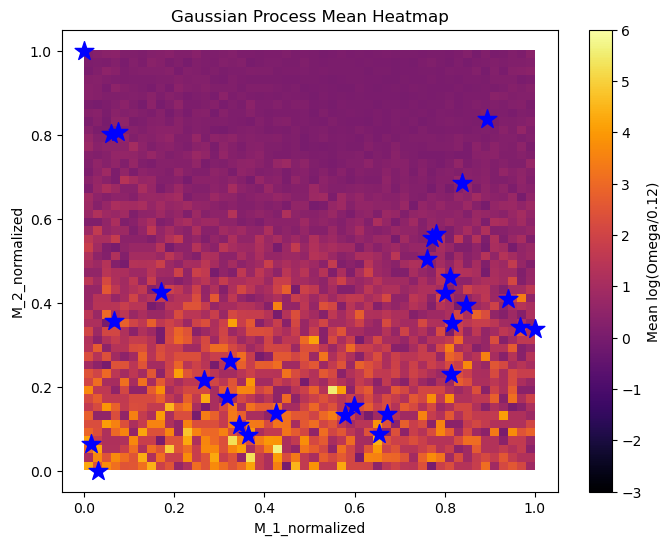

In [ ]:
x = x_test_rand[:, 0]
y = x_test_rand[:, 1]
z = mean_rand

vmin = -3
vmax = 6

# 2D-Histogramm berechnen
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, weights=z, density=True)

# Plotten der Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap.T, vmin=vmin, vmax=vmax, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Mean log(Omega/0.12)')
plt.xlabel('M_1_normalized')
plt.ylabel('M_2_normalized')
plt.title('Gaussian Process Mean Heatmap')

# Hervorheben der Trainingspunkte
plt.scatter(x_train[:, 0], x_train[:, 1], marker='*', s=200, c='b', label='Top 10 High Entropy Points')


plt.show()

Predicted vs. True

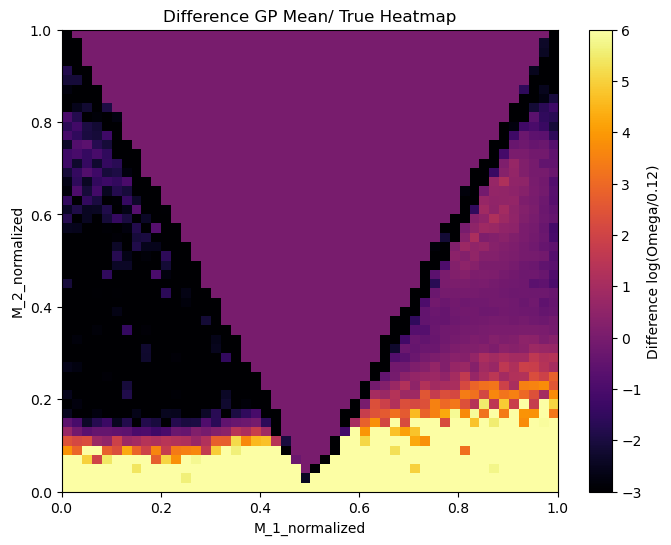

In [ ]:
x = x_test[:, 0]
y = x_test[:, 1]

# Predicted vs True
z = torch.tensor(mean) - torch.log(torch.tensor(Omega_filtered.values[n_points:n_test], dtype=torch.float32)/0.12)

# 2D-Histogramm berechnen
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, weights=z, density=True)

# Plotten der Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap.T, vmin=vmin, vmax=vmax, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Difference log(Omega/0.12)')
plt.xlabel('M_1_normalized')
plt.ylabel('M_2_normalized')
plt.title('Difference GP Mean/ True Heatmap')
plt.show()

True Function Heatmap

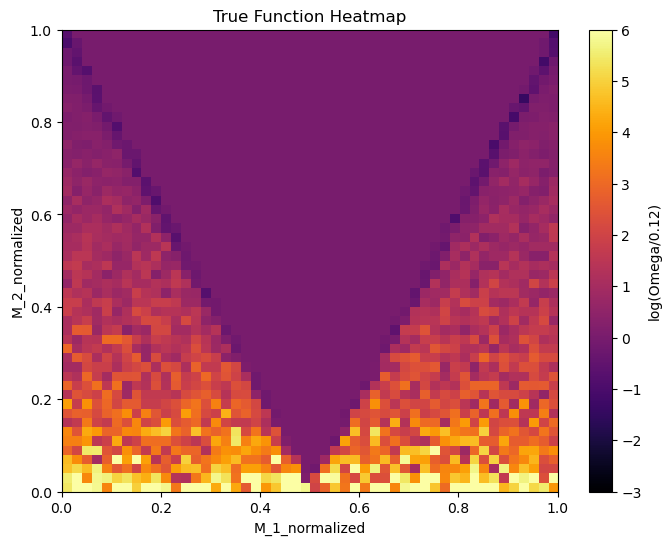

In [ ]:
x = x_test[:, 0]
y = x_test[:, 1]
z = torch.log(torch.tensor(Omega_filtered.values[n_points:n_test], dtype=torch.float32)/0.12)

# 2D-Histogramm berechnen
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, weights=z, density=True)

# Plotten der Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap.T, vmin=vmin, vmax=vmax, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='log(Omega/0.12)')
plt.xlabel('M_1_normalized')
plt.ylabel('M_2_normalized')
plt.title('True Function Heatmap')
plt.show()

Entropy Map

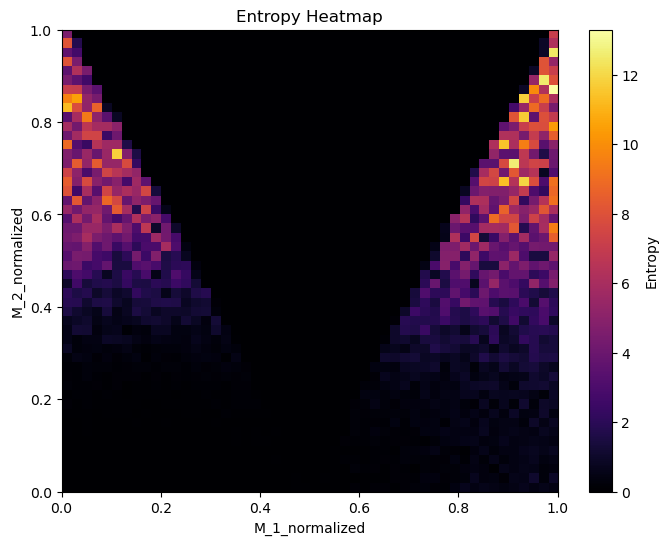

In [ ]:
# Beispiel-Daten
x = x_test[:, 0]
y = x_test[:, 1]
z = entropy

# 2D-Histogramm berechnen
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, weights=z, density=True)

# Plotten der Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Entropy')
plt.xlabel('M_1_normalized')
plt.ylabel('M_2_normalized')
plt.title('Entropy Heatmap')

plt.show()

In [ ]:
mean = observed_pred.mean.numpy()
lower, upper = observed_pred.confidence_region()

# Find the top 10 highest entropy values and their indices
topk_values, topk_indices = torch.topk(entropy, 10)
tenX = x_test[topk_indices]

maxE = torch.max(entropy)
maxIndex = torch.argmax(entropy)
maxX = x_test[maxIndex]

Highest Entropy Points

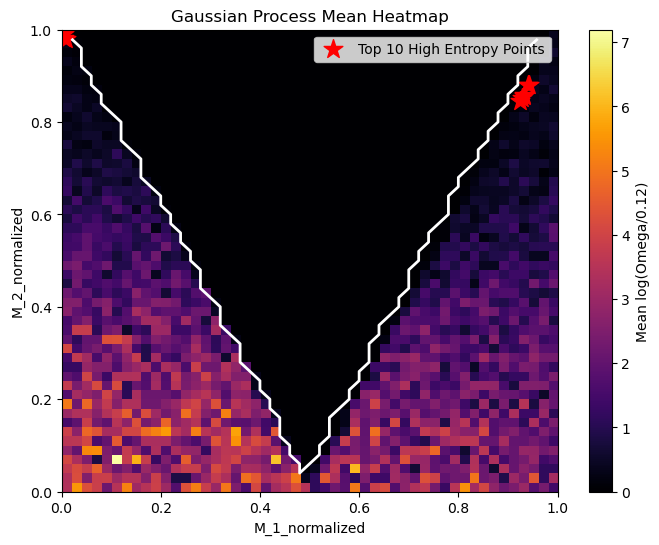

In [ ]:
# Beispiel-Daten
x = x_test[:, 0]
y = x_test[:, 1]
z = mean

# 2D-Histogramm berechnen
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, weights=z, density=True)

# Extrahieren der Top 10 Punkte mit höchster Entropie
topk_indices = torch.argsort(entropy, descending=True)[:10]
top_10_points = x_test[topk_indices]

# Plotten der Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Mean log(Omega/0.12)')
plt.xlabel('M_1_normalized')
plt.ylabel('M_2_normalized')
plt.title('Gaussian Process Mean Heatmap')

# Hervorheben der Top 10 Punkte als rote Sterne
plt.scatter(top_10_points[:, 0], top_10_points[:, 1], marker='*', s=200, c='r', label='Top 10 High Entropy Points')

# Contour wo mean > 0
plt.contour(xedges[:-1], yedges[:-1], heatmap.T, levels=[0], colors='white', linewidths=2, linestyles='solid')

# Legende hinzufügen
plt.legend()

plt.show()

1D Slice along M_2 with entropy

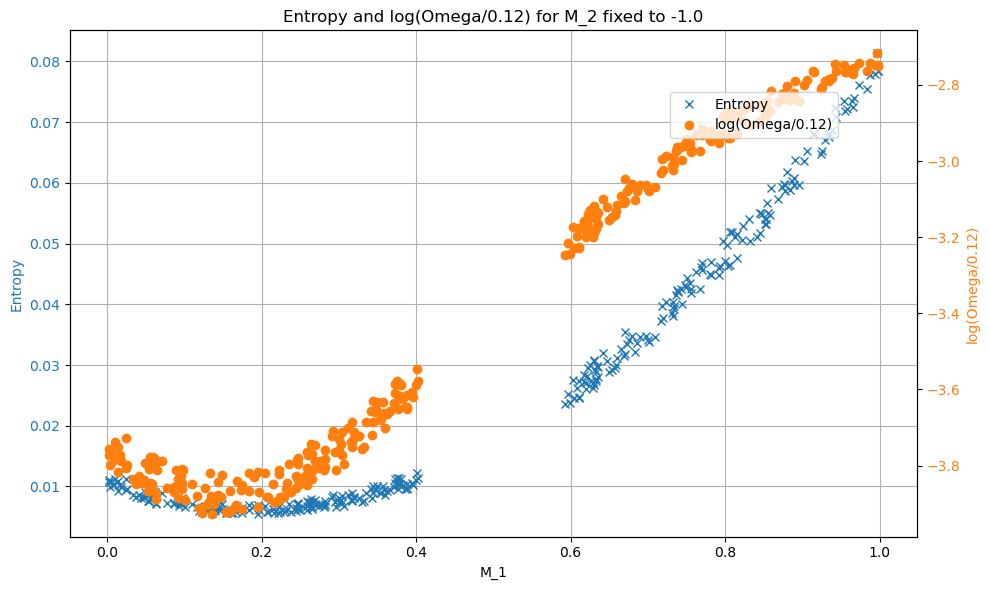

In [ ]:
# Filter indices where x_test[:, 1] is approximately 0.2 with a tolerance of 0.1
tolerance = 0.01
indices = np.where((x_test[:, 1] >= 0.2 - tolerance) & (x_test[:, 1] <= 0.2 + tolerance))[0]


# Get the corresponding x_test[:, 0] and entropy values
x_test_filtered = x_test[indices, 0]
entropy_filtered = entropy[indices]
y_test_filtered = mean[indices]


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot entropy on the primary y-axis
ax1.plot(x_test_filtered, entropy_filtered, 'x', label='Entropy', color='tab:blue')
ax1.set_xlabel('M_1')
ax1.set_ylabel('Entropy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a secondary y-axis for log(Omega/0.12)
ax2 = ax1.twinx()
ax2.plot(x_test_filtered, y_test_filtered, 'o', label='log(Omega/0.12)', color='tab:orange')
ax2.set_ylabel('log(Omega/0.12)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title
plt.title('Entropy and log(Omega/0.12) for M_2 fixed to -1.0')

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Show plot
plt.tight_layout()
plt.show()

1D Slice along M_1 with entropy

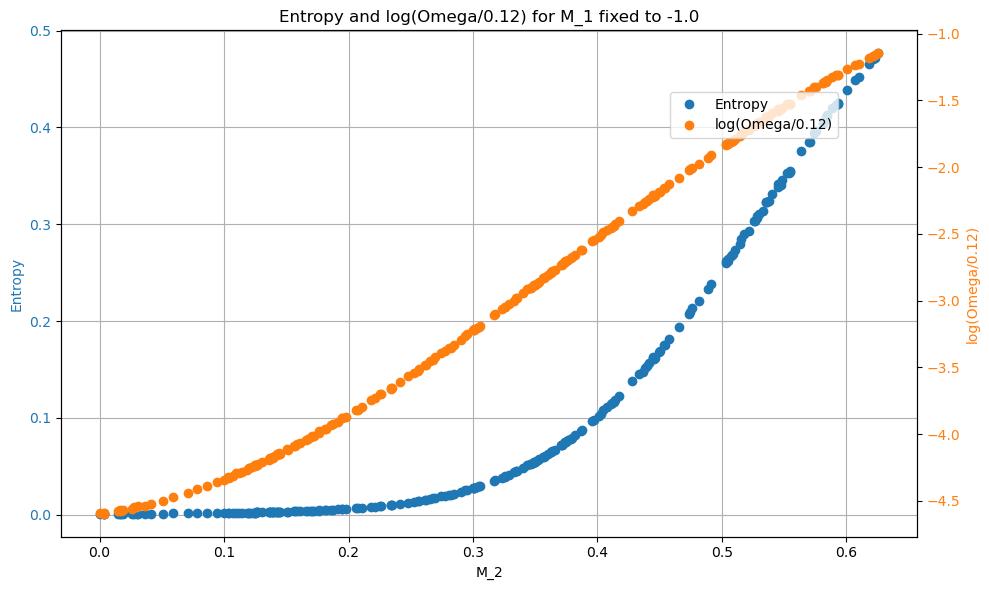

In [ ]:
# Filter indices where x_test[:, 0] is approximately 0.2 with a tolerance of 0.1
tolerance = 0.01
indices = np.where((x_test[:, 0] >= 0.2 - tolerance) & (x_test[:, 0] <= 0.2 + tolerance))[0]


# Get the corresponding x_test[:, 1] and entropy values
x_test_filtered = x_test[indices, 1]
entropy_filtered = entropy[indices]
y_test_filtered = mean[indices]


# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot entropy on the primary y-axis
ax1.plot(x_test_filtered, entropy_filtered, 'o', label='Entropy', color='tab:blue')
ax1.set_xlabel('M_2')
ax1.set_ylabel('Entropy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a secondary y-axis for log(Omega/0.12)
ax2 = ax1.twinx()
ax2.plot(x_test_filtered, y_test_filtered, 'o', label='log(Omega/0.12)', color='tab:orange')
ax2.set_ylabel('log(Omega/0.12)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title
plt.title('Entropy and log(Omega/0.12) for M_1 fixed to -1.0')

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Show plot
plt.tight_layout()
plt.show()

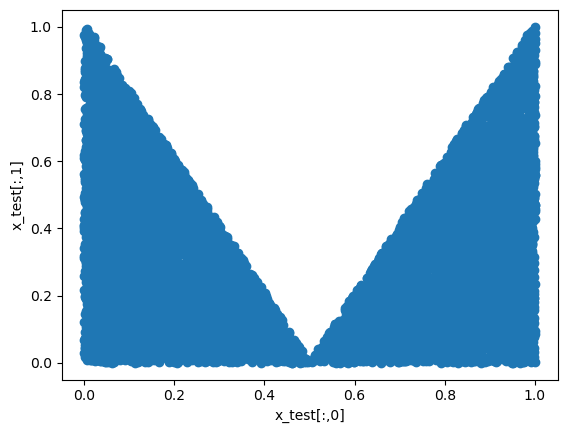

In [ ]:
plt.xlabel("x_test[:,0]")
plt.ylabel("x_test[:,1]")
plt.scatter(x_test[:,0], x_test[:,1])

Smoothed Plot Version

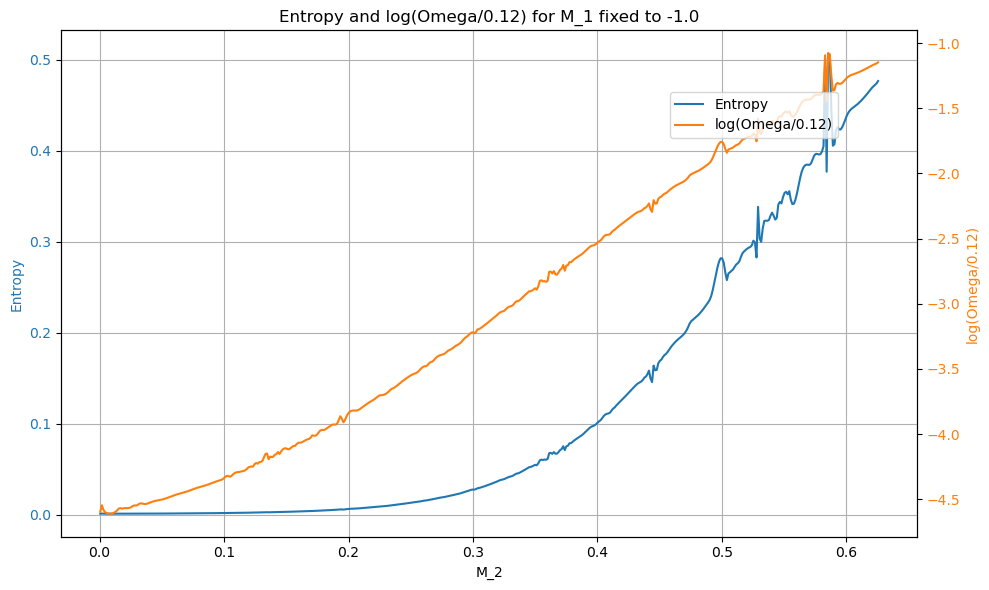

In [ ]:
from scipy.interpolate import make_interp_spline

# Sample data (replace with your actual data)
x_test_filtered = np.array(x_test_filtered)
entropy_filtered = np.array(entropy_filtered)
y_test_filtered = np.array(y_test_filtered)

# Sort the data by x_test_filtered to ensure the interpolation works correctly
sorted_indices = np.argsort(x_test_filtered)
x_test_sorted = x_test_filtered[sorted_indices]
entropy_sorted = entropy_filtered[sorted_indices]
y_test_sorted = y_test_filtered[sorted_indices]

# Generate smooth curves using cubic spline interpolation
x_smooth = np.linspace(x_test_sorted.min(), x_test_sorted.max(), 500)
entropy_spline = make_interp_spline(x_test_sorted, entropy_sorted, k=3)(x_smooth)
y_test_spline = make_interp_spline(x_test_sorted, y_test_sorted, k=3)(x_smooth)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot entropy on the primary y-axis
ax1.plot(x_smooth, entropy_spline, label='Entropy', color='tab:blue')
ax1.set_xlabel('M_2')
ax1.set_ylabel('Entropy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a secondary y-axis for log(Omega/0.12)
ax2 = ax1.twinx()
ax2.plot(x_smooth, y_test_spline, label='log(Omega/0.12)', color='tab:orange')
ax2.set_ylabel('log(Omega/0.12)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Add a title
plt.title('Entropy and log(Omega/0.12) for M_1 fixed to -1.0')

# Add legends
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
def plotGP(new_x = None):
    """Plot GP inclusive entropy"""

    mean = observed_pred.mean.numpy()
    lower, upper = observed_pred.confidence_region()

    # # Initialize plot
    # _, ax = plt.subplots(1, 1, figsize=(10, 6))

    # # Plot training data as black stars
    # ax.plot(x_train.numpy(), y_train.numpy(), 'k*', label='Training Data')
    # # Plot predictive means as blue line
    # ax.plot(x_test.numpy(), mean, 'b', label='Learnt Function')
    # # Shade between the lower and upper confidence bounds
    # ax.fill_between(x_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.5, label='Confidence')
    # # ax.set_ylim([-3, 3])
    # ax.plot(x_test, y_test, 'r', label='Truth')

    # # Add new points to be evaluated:
    # if new_x is not None:
    #     dolabel = True
    #     for xval in new_x:
    #         ax.axvline(x=xval, color='r', linestyle='--', label='new points') if dolabel else ax.axvline(x=xval, color='r', linestyle='--')
    #         dolabel = False

    # ax2 = ax.twinx()
    # ax2.set_ylabel("entropy")
    # ax2.plot(x_test, entropy, 'g', label='Entropy')

    maxE = torch.max(entropy)
    maxIndex = torch.argmax(entropy)
    maxX = x_test[maxIndex]
    # ax2.plot(maxX, maxE, 'go', label='Max. E')

    # add common legend:
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax2.legend(lines + lines2, labels + labels2)

plotGP()

Find new target for training based on entropy (skipping batch acquisiton for now)

In [ ]:
maxE = torch.max(entropy)
maxIndex = torch.argmax(entropy)
maxX = x_test[maxIndex]
print(torch.tensor([maxX]))

print(f"Maximum entropy E={torch.max(entropy)} at x={maxX}")

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
print(x_train.shape)
print(maxX.shape)
x_train = torch.cat((x_train, maxX), dim=0)
x_train = torch.cat((x_train, torch.tensor([maxX])), dim=0)
y_train = torch.cat((y_train, objective(torch.tensor([maxX]))), dim=0) # Here i could use the mean instead of the evaluated function

x_train, y_train

torch.Size([10, 2])
torch.Size([2])


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

Re-train with added sample:

In [ ]:
multitask_gp = MultitaskGP(x_train, y_train, x_valid, y_valid, likelihood)
best_multitask_gp, losses, losses_valid = multitask_gp.do_train_loop(iters=2000)

Iter 1 / 2000 - Loss (Train): 1.378 - Loss (Val): 1.318
Iter 101 / 2000 - Loss (Train): 0.970 - Loss (Val): -0.370
Iter 201 / 2000 - Loss (Train): 0.164 - Loss (Val): -2.402
Iter 301 / 2000 - Loss (Train): 0.159 - Loss (Val): -2.391
Iter 401 / 2000 - Loss (Train): 0.157 - Loss (Val): -2.388
Iter 501 / 2000 - Loss (Train): 0.156 - Loss (Val): -2.390
Iter 601 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.387
Iter 701 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 801 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.391
Iter 901 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.392
Iter 1001 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 1101 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.391
Iter 1201 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.390
Iter 1301 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.389
Iter 1401 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.392
Iter 1501 / 2000 - Loss (Train): 0.155 - Loss (Val): -2.393
Iter 1601 / 2000 - Loss (Train): 0.155 - Loss (Val): 

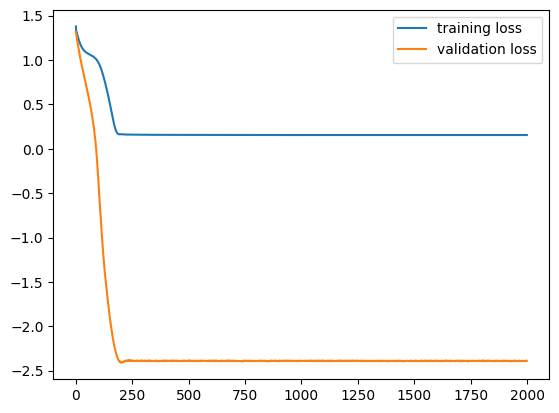

In [ ]:
plt.plot(losses, label='training loss')
plt.plot(losses_valid, label='validation loss')
plt.legend()

Evaluate again & plot the updated GP:

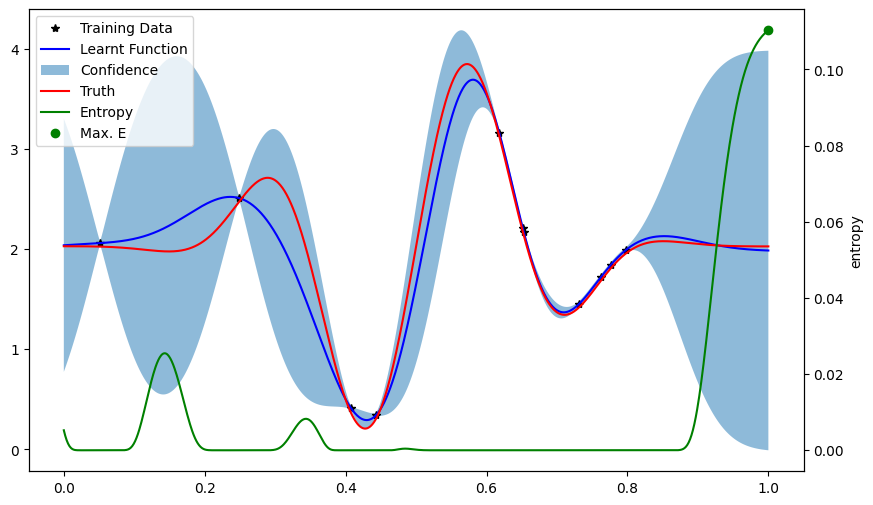

In [ ]:
observed_pred, entropy = evaluate(multitask_gp, likelihood, x_test)
plotGP()

Closing the loop with batch acquisition:

In [ ]:
def best_not_yet_chosen(score, previous_indices):

  candidates = torch.sort(score, descending = True)[1]

  for next_index in candidates:
    if int(next_index) not in previous_indices:
      return next_index

def iterative_batch_selector(score_function, 
                             choice_function = best_not_yet_chosen,
                             gp_mean = None, 
                             gp_covar= None, 
                             N = None):

  #make it a decorator
  if gp_mean is None:
    def greedy_batch_sel(gp_mean, gp_covar, N):
      return iterative_batch_selector(score_function, choice_function, gp_mean, gp_covar, N)
    return greedy_batch_sel
  


  #actual_function starts here

  #First point greedy
  score = score_function(gp_mean[:,None], torch.diag(gp_covar)[:,None,None])
  first_index = torch.argmax(score)
  indices = [int(first_index)]

  #Iterate for all points
  num_pts = len(gp_mean)

  for i in range(N-1):

    #Create the batched cov matrices
    center_cov = torch.stack([gp_covar[indices,][:,indices]]*num_pts)
    side_cov = gp_covar[:,None,indices]
    bottom_cov =  gp_covar[:,indices, None]
    end_cov = torch.diag(gp_covar)[:,None,None]

    cov_batch = torch.cat([
                  torch.cat([center_cov, side_cov],axis = 1),
                  torch.cat([bottom_cov, end_cov ],axis = 1),
                  ], axis = 2)
    
    #Create the batched mean vectors
    center_mean = torch.stack([gp_mean[indices,]]*num_pts)
    new_mean = gp_mean[:,None]


    mean_batch = torch.cat([center_mean,new_mean],axis=1)

    score = score_function(mean_batch,cov_batch)

    next_index = choice_function(score, indices)

    indices.append(int(next_index))

  return indices

In [ ]:
def approximate_batch_entropy(mean, cov):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  mean = mean
  n = mean.shape[-1]
  d = torch.diag_embed(1./mean).to(device) #like torch.diag but batches well
  x = d@cov@d.to(device)
  I = torch.eye(n)[None,:,:].to(device)
  return (torch.logdet(x+I)-torch.logdet(x+2*I)+n*np.log(2))/np.log(2)

def smoothed_batch_entropy(blur):
  return lambda mean,cov: approximate_batch_entropy(mean+blur*torch.sign(mean),cov)

def gibbs_sample(beta):

  def sampler(score,indices = None):
    probs = torch.exp(beta*(score-torch.max(score)))
    probs/=torch.sum(probs)
    cums = torch.cumsum(probs,dim=0)
    rand = torch.rand(size = (1,))[0]
    return torch.sum(cums<rand)

  return sampler

Use selector to make choice which points to sample:

In [ ]:
selector = iterative_batch_selector(score_function = smoothed_batch_entropy(blur = 0.15),
                                    choice_function = gibbs_sample(beta = 50))  #100 BETTER

with torch.no_grad(), gpytorch.settings.fast_pred_var():

  # take observed_pred from test points
  mean = observed_pred.mean.detach()
  covar = observed_pred.covariance_matrix.detach()
  thr = torch.Tensor([0.]) # threshold in CDF calculation. Needs to be more sophisticated if params are scaled.

  points = set(selector(N=4, gp_mean=mean-thr, gp_covar=covar) )
  new_x = x_test[list(points)]
  
print("points:", points)
print("Corresponding xs:", new_x)

points: {968, 223, 127, 999}
Corresponding xs: tensor([0.9690, 0.2232, 0.1271, 1.0000])


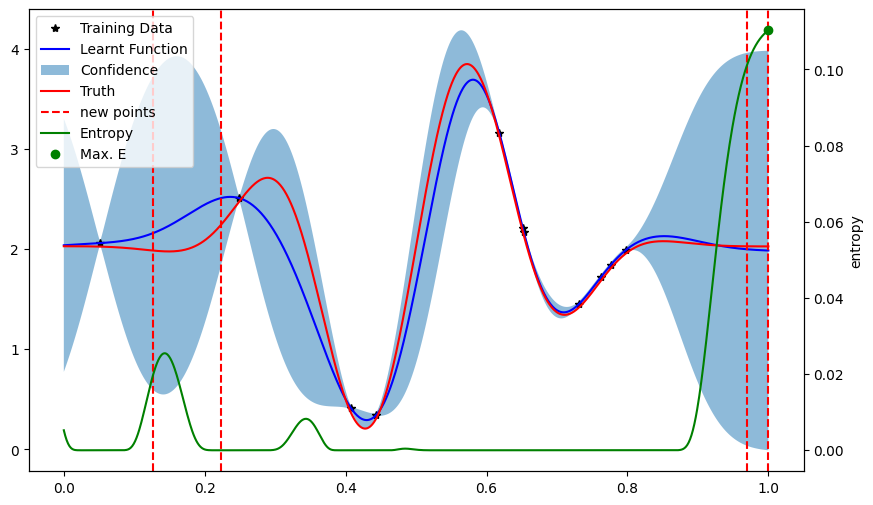

In [ ]:
plotGP(new_x=new_x)